In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, explained_variance_score, median_absolute_error, max_error
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
import itertools
import joblib
import json
import csv

In [2]:
model_info = {
    'model_name': 'Decision Tree Classifier',
    'training_file': 'MLM_Decision_Tree_Classifier.ipynb',
    'file_name': 'model_dtc.pkl',
    'scaler_file': 'model_dtc_scaler.pkl',
    'prepared_by': 'Digital Khalid',
    'library': 'Scikit-Learn',
    'algorithm': 'Decision Tree Classifier',
    'normalization': 'Standard Scaler (Z-Score)',
    'data_file': '../datasets/mawi_flows.csv',
    'features': ['source_port', 'destination_port', 'protocol', 'first_pkt_size'],
    'target': ['flow_class'],
}

In [3]:
# Save model information as json file
with open(f'model_info_{model_info["model_name"]}.json', "w") as outfile:
    json.dump(model_info, outfile)

In [4]:
# Read data file
input_file = model_info['data_file']
input_file
flows = pd.read_csv(input_file)

### Dataset Adjustments

In [5]:
flows['idle_timeout'].value_counts()

idle_timeout
1     1322070
11      88210
4       21363
2       18775
8       15163
9       15087
3       11325
5        9353
10       8798
6        4577
7        3669
Name: count, dtype: int64

In [6]:
features = model_info['features']
target = model_info['target']

X = flows[features]
y = flows[target]

In [7]:
print(f'features (X)\n{X}')

features (X)
         source_port  destination_port  protocol  first_pkt_size
0               1999             54524         6              66
1              50005              3479        17             183
2              44734               443         6              54
3              43332              3128         6              54
4              61554               443         6              85
...              ...               ...       ...             ...
1518385        48152              3128         6              58
1518386         7528                80         6              58
1518387           80             12256         6              66
1518388        44843              2375         6              54
1518389        50355             43527         6              58

[1518390 rows x 4 columns]


In [8]:
print(f'features (y)\n{y}')

features (y)
         flow_class
0                 3
1                 3
2                 2
3                 1
4                 1
...             ...
1518385           1
1518386           1
1518387           1
1518388           1
1518389           1

[1518390 rows x 1 columns]


In [9]:
# Data Normalization
scaler = StandardScaler()

# Fit the scaler on the training set and transform the training set
X_norm = scaler.fit_transform(X)
X_norm

array([[-1.48137583,  2.11086118, -0.33874667, -0.11701203],
       [ 0.75371663, -0.59077602,  2.95205852,  1.07173183],
       [ 0.50830622, -0.75146112, -0.33874667, -0.23893448],
       ...,
       [-1.5707218 , -0.12623944, -0.33874667, -0.11701203],
       [ 0.51338111, -0.64920697, -0.33874667, -0.23893448],
       [ 0.77001214,  1.52882759, -0.33874667, -0.19829367]])

In [10]:
joblib.dump(scaler, model_info['scaler_file'])

['model_dtc_scaler.pkl']

In [13]:
flows['flow_class'].value_counts()/ flows.shape[0] * 100

flow_class
1    84.097696
2     9.804793
3     6.097511
Name: count, dtype: float64

### Cost Effective Decision Tree (Balanced)

In [45]:
# define model
model = DecisionTreeClassifier(class_weight='balanced')

In [46]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [52]:
scores = cross_val_score(model, X_norm, y, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   42.9s finished


In [54]:
np.mean(scores)

0.5613046076671847

### Cost Effective Decision Tree (Using multiple class weights and hyperparameters with Grid Search CV)

In [24]:
# define model
model = DecisionTreeRegressor()

In [81]:
# define grid
# balance = [{0:1,1:1000}, {0:1,1:500}, {0:1,1:250}]
# class_weight = [{0:1,1:1500}, {0:1,1:2500}]
max_depth = [5, 10]
min_samples_split = [5, 10]
criterion = ['absolute_error', 'squared_error', 'poisson', 'friedman_mse']
splitter = ['best', 'random']

param_grid = {
    # 'class_weight': class_weight,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'criterion': criterion,
    'splitter': splitter,
}

In [82]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=1, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-3, cv=cv, scoring='neg_mean_squared_error', verbose=3)

In [83]:
# execute the grid search
grid_result = grid.fit(X_norm, y)

Fitting 2 folds for each of 32 candidates, totalling 64 fits


KeyboardInterrupt: 

In [133]:
# report the best configuration
print()
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.970502 using {'class_weight': {0: 1, 1: 1500}, 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5, 'splitter': 'best'}
0.945225 (0.006527) with: {'class_weight': {0: 1, 1: 1500}, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 5, 'splitter': 'best'}
0.879478 (0.021756) with: {'class_weight': {0: 1, 1: 1500}, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 5, 'splitter': 'random'}
0.945225 (0.006527) with: {'class_weight': {0: 1, 1: 1500}, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 10, 'splitter': 'best'}
0.870731 (0.021427) with: {'class_weight': {0: 1, 1: 1500}, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 10, 'splitter': 'random'}
0.945225 (0.006527) with: {'class_weight': {0: 1, 1: 1500}, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 15, 'splitter': 'best'}
0.868124 (0.024640) with: {'class_weight': {0: 1, 1: 1500}, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 15, 'splitter': 'random'}
0.97050

### Cost Effective Decision Tree (Using best hyperparameters)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, random_state=1, test_size=0.25, stratify=y)

In [22]:
def test_hyperparameters(class_weight, max_depth, min_sample_split, criterion, splitter, log):
    best_param_grid = {
        'class_weight': class_weight,
        'max_depth': max_depth,
        'min_samples_split': min_sample_split,
        'criterion': criterion,
        'splitter': splitter,
    }
    
    # define model
    model = DecisionTreeClassifier(**best_param_grid)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Evaluate the model's performance
    precision = precision_score(y_test, y_pred, average = 'macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average = 'macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average = 'macro', zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    # fpr, tpr, _ = roc_curve(y_test, y_pred)
    # roc_auc = auc(fpr, tpr)

    log_val = [max_depth, min_sample_split, criterion, splitter, precision, recall, f1, accuracy]
    print(log_val)
    
    if log == True:
        log_file = 'log_dtc_training.csv'
        
        with open(log_file, 'a', newline = '') as logs:
            writer = csv.writer(logs)
            writer.writerow(log_val)

In [23]:
class_weight = [{1:1.19, 2:10, 3:16.66}]
max_depth = [3, 5, 10]
min_sample_split = [3, 5, 10]
criterion = ['gini', 'entropy']
splitter = ['best', 'random']
log = True

for i in class_weight:
    for j in max_depth:
        for k in min_sample_split:
            for l in criterion:
                for m in splitter:
                    test_hyperparameters(i, j, k, l, m, log)

[3, 3, 'gini', 'best', 0.5202426551676101, 0.5748203938695495, 0.48964131591962196, 0.7047850620920026]
[3, 3, 'gini', 'random', 0.39576754607228065, 0.4939304914329308, 0.3485815927644082, 0.500993155917576]
[3, 3, 'entropy', 'best', 0.5201233936759574, 0.5747397704322489, 0.49025843391420615, 0.7064763249542938]
[3, 3, 'entropy', 'random', 0.3937996687912542, 0.4848866168511128, 0.3710310858912546, 0.690161697374591]
[3, 5, 'gini', 'best', 0.5202426551676101, 0.5748203938695495, 0.48964131591962196, 0.7047850620920026]
[3, 5, 'gini', 'random', 0.3991566036104635, 0.4926672659257596, 0.3614076189434335, 0.5740151423347858]
[3, 5, 'entropy', 'best', 0.5201233936759574, 0.5747397704322489, 0.49025843391420615, 0.7064763249542938]
[3, 5, 'entropy', 'random', 0.4743060520117887, 0.4824440447445169, 0.33961862467701853, 0.6133409554317989]
[3, 10, 'gini', 'best', 0.5202426551676101, 0.5748203938695495, 0.48964131591962196, 0.7047850620920026]
[3, 10, 'gini', 'random', 0.41521885551887455, 

In [28]:
best_param_grid = {
    'class_weight': {1:1.19, 2:10, 3:16.66},
    'max_depth': 10,
    'min_samples_split': 3,
    'criterion': 'gini',
    'splitter': 'best',
}

# define model
model = DecisionTreeClassifier(**best_param_grid)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [33]:
# Evaluate the model's performance
precision = precision_score(y_test, y_pred, average = 'macro', zero_division=0)
print("Precision:", precision)

recall = recall_score(y_test, y_pred, average = 'macro', zero_division=0)
print("Recall:", recall)

f1 = f1_score(y_test, y_pred, average = 'macro', zero_division=0)
print("F1 Score:", f1)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Precision: 0.5973266461835044
Recall: 0.70087201335196
F1 Score: 0.6104672575144885
Accuracy: 0.8137608733449597


In [30]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [32]:
scores = cross_val_score(model, X_norm, y, scoring='roc_auc', cv=cv, n_jobs=-2)
np.mean(scores)

/home/dk/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dk/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 136, in __call__
    score = scorer._score(
  File "/home/dk/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/home/dk/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dk/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 136, in __call__
    score = scorer._score(
  File "/home/dk/.

KeyboardInterrupt: 

### Save Model File

In [34]:
joblib.dump(model, model_info['file_name'])

['model_dtc.pkl']

### Load Model File (Further Evaluation)

In [45]:
model = joblib.load(model_info['file_name'])

In [46]:
scaler = joblib.load(model_info['scaler_file'])

In [47]:
model.feature_importances_

array([0.45582965, 0.17870386, 0.15636848, 0.20909801])

In [48]:
features = model_info['features']
target = model_info['target']

X = flows[features]
y = flows[target]

In [49]:
X_norm = scaler.transform(X)

In [50]:
predictions = model.predict(X_norm)

In [51]:
predictions

array([4.29153208, 1.21693879, 1.77046287, ..., 1.57864256, 1.77046287,
       1.00264263])

In [52]:
predictions = pd.Series(predictions, index=X.index)
predictions

0          4.291532
1          1.216939
2          1.770463
3          1.770463
4          2.956808
             ...   
1518385    1.017981
1518386    1.106996
1518387    1.578643
1518388    1.770463
1518389    1.002643
Length: 1518390, dtype: float64

In [53]:
pred_flows = pd.concat([X, y, predictions], axis=1)
pred_flows

,source_port,destination_port,protocol,first_pkt_size,idle_timeout,0
0,1999,54524,6,66,11,4.291532
1,50005,3479,17,183,1,1.216939
2,44734,443,6,54,4,1.770463
3,43332,3128,6,54,1,1.770463
4,61554,443,6,85,1,2.956808
...,...,...,...,...,...,...
1518385,48152,3128,6,58,1,1.017981
1518386,7528,80,6,58,1,1.106996
1518387,80,12256,6,66,1,1.578643
1518388,44843,2375,6,54,1,1.770463


In [54]:
pred_flows.rename(columns={'idle_timeout': 'actual_idle_timeout'}, inplace=True)

In [55]:
pred_flows.rename(columns={0: 'predicted_idle_timeout'}, inplace=True)

In [58]:
pred_flows['predicted_idle_timeout'] = pred_flows['predicted_idle_timeout'].astype(int)

In [59]:
pred_flows

,source_port,destination_port,protocol,first_pkt_size,actual_idle_timeout,predicted_idle_timeout
0,1999,54524,6,66,11,4
1,50005,3479,17,183,1,1
2,44734,443,6,54,4,1
3,43332,3128,6,54,1,1
4,61554,443,6,85,1,2
...,...,...,...,...,...,...
1518385,48152,3128,6,58,1,1
1518386,7528,80,6,58,1,1
1518387,80,12256,6,66,1,1
1518388,44843,2375,6,54,1,1


In [60]:
# Save dataset with predictions as a csv file without index
output_file = 'datasets/flows_predicted.csv'
pred_flows.to_csv(output_file, index=False)
print('Done')

Done


In [64]:
misclassifications = pred_flows.query('actual_idle_timeout == predicted_idle_timeout')

In [66]:
misclassifications['predicted_idle_timeout'].value_counts()

predicted_idle_timeout
1     1138599
4       13410
2        1669
3          28
6          28
10         18
7          11
8           5
Name: count, dtype: int64

In [ ]:
# Save misclassified dataset as a csv file without index
output_file = 'flows_misclassified.csv'
misclassifications.to_csv(output_file, index=False)
print('Done')

In [129]:
pred_elephants = pred_flows.query('predicted_elephant==1')

In [132]:
# Save all predicted elephant flows as a csv file without index
output_file = 'flows_predicted_elephants.csv'
pred_elephants.to_csv(output_file, index=False)
print('Done')

Done


In [24]:
# pd.set_option('display.max_rows', None)
pred[pred['predicted_elephant'] == 1].value_counts()

src_port  dst_port  protocol  first_pkt_size  flow_size  packet_count  actual_elephant  predicted_elephant
5100      5060      17        457             457        1             0                1                     8599
                              456             456        1             0                1                     7308
500       500       17        246             246        1             0                1                     5789
5100      5060      17        458             458        1             0                1                     5342
                              455             455        1             0                1                     4546
                                                                                                              ... 
1178      46905     17        62              186        3             0                1                        1
1179      48985     6         58              58         1             0                

In [26]:
pred.query('src_port==0 & dst_port==0 & actual_elephant==0 & predicted_elephant==1').value_counts()

src_port  dst_port  protocol  first_pkt_size  flow_size  packet_count  actual_elephant  predicted_elephant
0         0         47        1502            15618      67            0                1                     1
Name: count, dtype: int64

In [59]:
pred.query('protocol==17 & actual_elephant==1 & predicted_elephant==1').value_counts()

src_port  dst_port  protocol  first_pkt_size  flow_size  packet_count  actual_elephant  predicted_elephant
80        57777     17        63              112266     1782          1                1                     2
          39308     17        176             670490     3707          1                1                     1
1194      55802     17        82              1276639    1058          1                1                     1
3214      8801      17        106             372458     2103          1                1                     1
3074      30480     17        170             518189     3379          1                1                     1
                                                                                                             ..
443       56006     17        1292            143546     117           1                1                     1
          55921     17        1392            1400915    1031          1                1                    

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, random_state=1, test_size=0.25, stratify=y)

In [30]:
y_pred = model.predict(X_test)

In [31]:
# Evaluate the model's performance
precision = precision_score(y_test, y_pred, average = 'macro', zero_division=0)
print("Precision:", precision)

recall = recall_score(y_test, y_pred, average = 'macro', zero_division=0)
print("Recall:", recall)

f1 = f1_score(y_test, y_pred, average = 'macro', zero_division=0)
print("F1 Score:", f1)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(f'False Positive Rate: {fpr[1]}\nTrue Positive Rate: {tpr[1]}\nROC_AUC: {roc_auc}')

Precision: 0.5024234041552332
Recall: 0.8977760290415926
F1 Score: 0.45221876812560585
Accuracy: 0.8097370966285006
False Positive Rate: 0.19042925032802974
True Positive Rate: 0.985981308411215
ROC_AUC: 0.8977760290415926


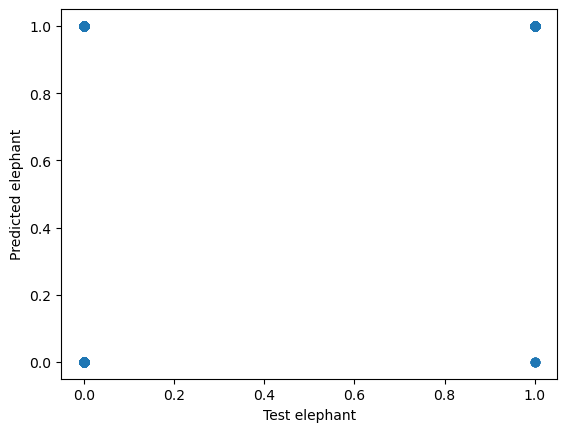

In [32]:
fig, ax = plt.subplots()
ax.set_xlabel('Test ' + target[0])
ax.set_ylabel('Predicted ' + target[0])
ax.scatter(y_test, y_pred)

(array([367118.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  86775.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

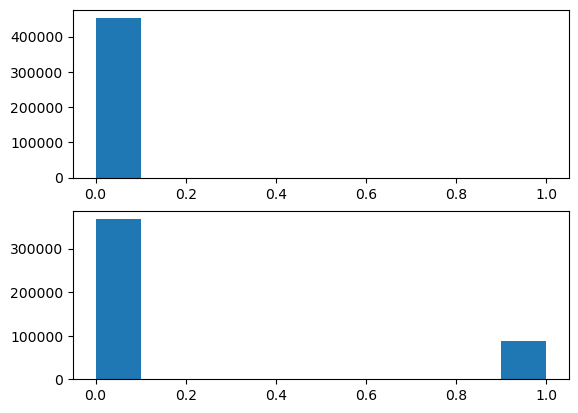

In [33]:
fig, ax = plt.subplots(2)
ax[0].hist(y_test)
ax[1].hist(y_pred)

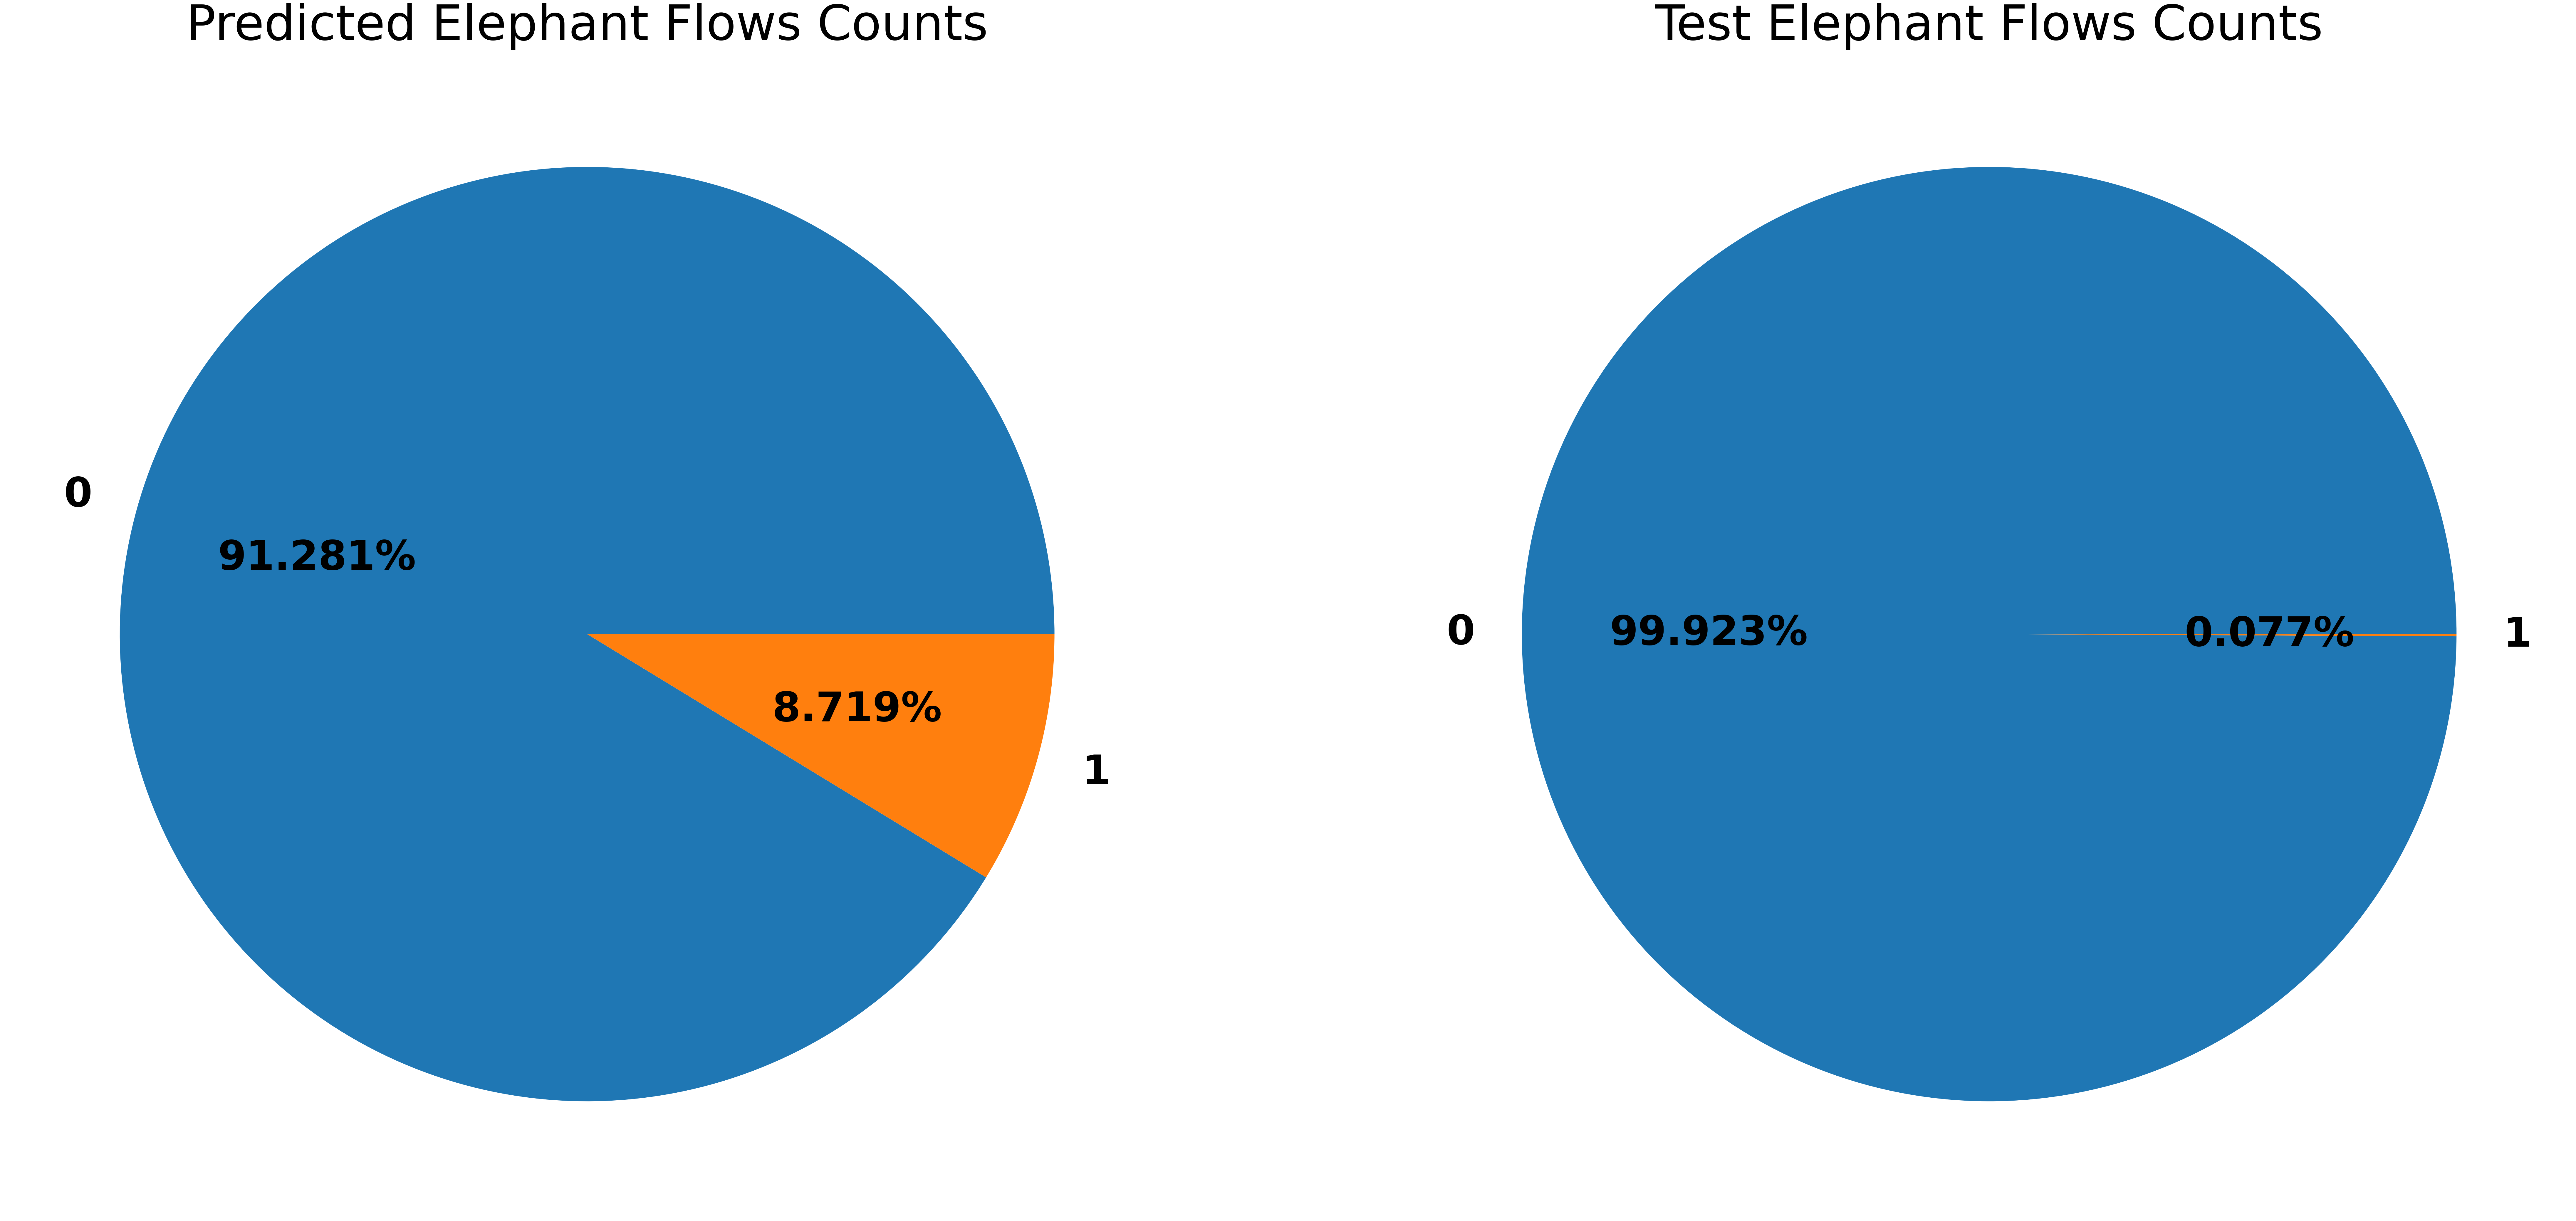

In [96]:
predictions = pd.DataFrame(y_pred)
testset = pd.DataFrame(y_test)

# get the set of distinct classes
labels_pred = predictions[0].unique()
labels_test = testset.elephant.unique()

# get the count of each class
sizes_pred = predictions[0].value_counts().values
sizes_test = testset.elephant.value_counts().values

font = {#'family' : 'normal',
        'weight' : 'bold',
        'size'   : 100}

matplotlib.rc('font', **font)

# plot the class value counts
fig, ax = plt.subplots(1, 2, sharey='row', figsize=(100, 100))
plt.subplots_adjust(bottom=0.1, right=1, top=0.5)

ax[0].pie(sizes_pred, labels=labels_pred, autopct='%1.3f%%')
ax[0].set_title('Predicted Elephant Flows Counts')

ax[1].pie(sizes_test, labels=labels_test, autopct='%1.3f%%')
ax[1].set_title('Test Elephant Flows Counts')

plt.show()

In [97]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, y_pred, labels=[1,0]))

[[   341      9]
 [ 39232 414311]]


Confusion matrix, without normalization
[[   341      9]
 [ 39232 414311]]


/tmp/ipykernel_16580/232926455.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


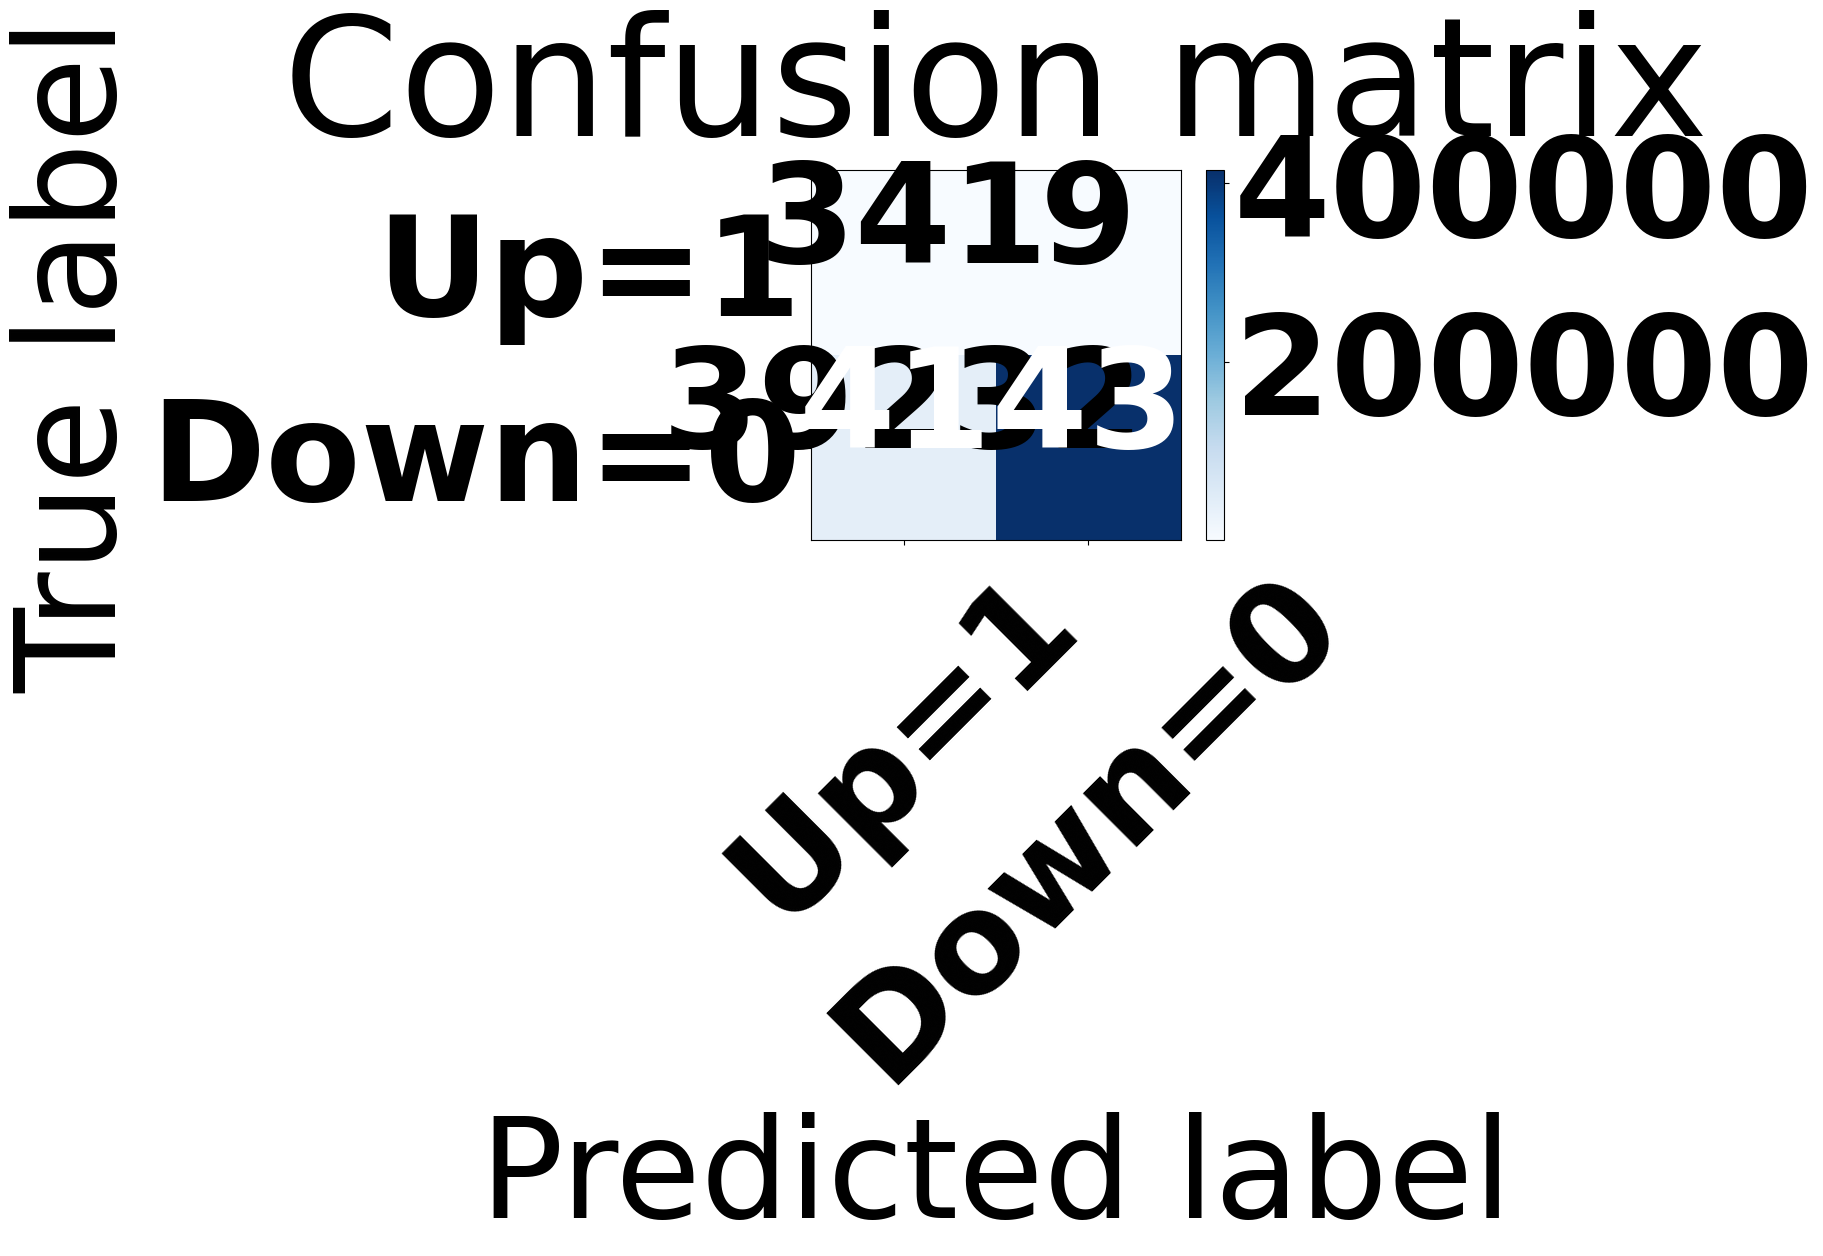

In [98]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Up=1','Down=0'], normalize=False, title='Confusion matrix')


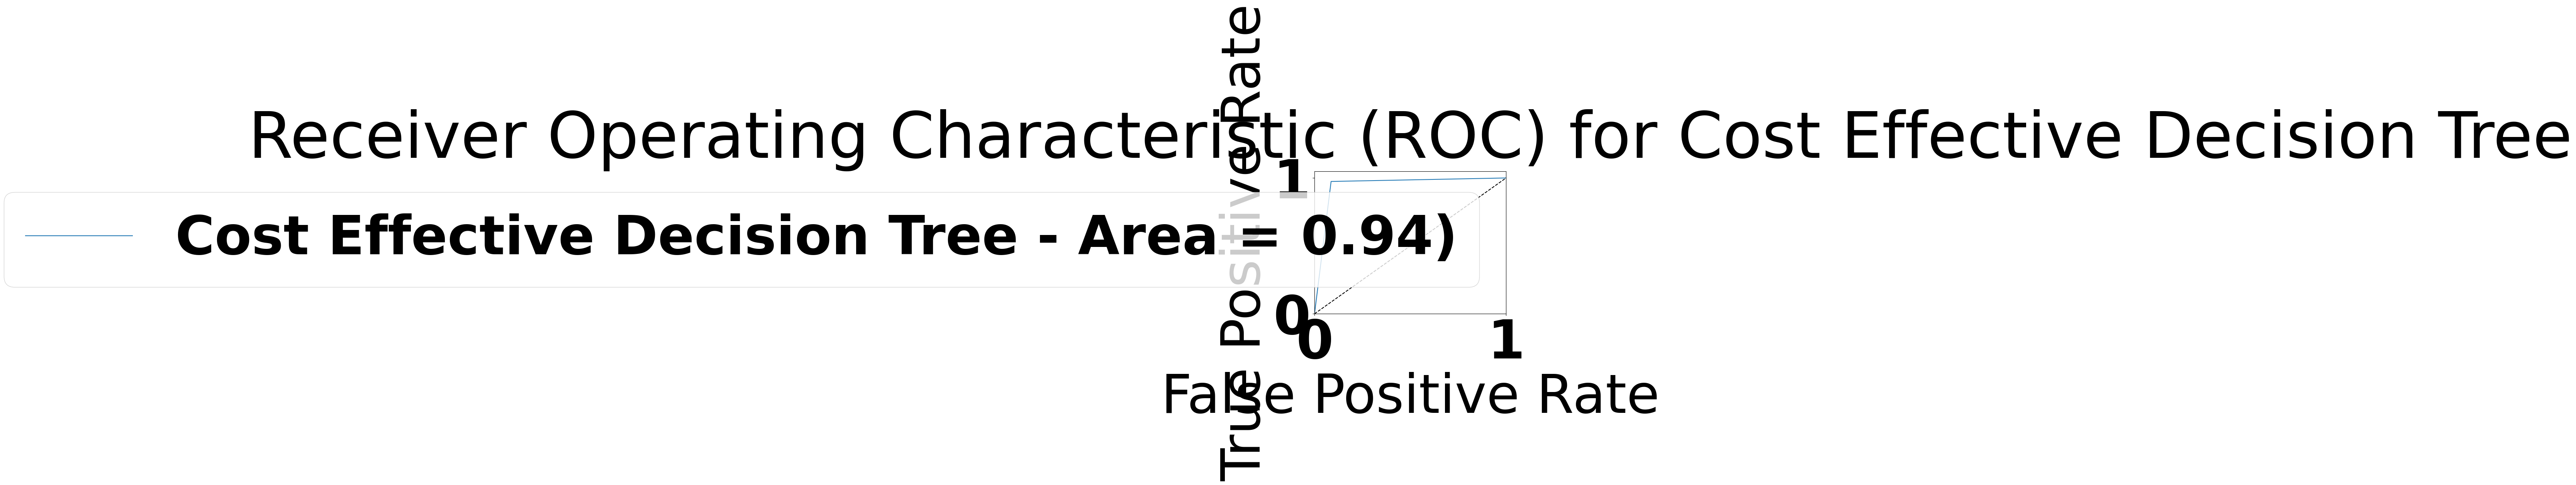

In [99]:
# Plot ROC curve
plt.plot(fpr, tpr, label=f"Cost Effective Decision Tree - Area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) for Cost Effective Decision Tree')
plt.legend(loc="lower right")

# Save the ROC curve plot as an image
# plt.savefig(f"ROC_Curve_CEDT.png")

# Show the ROC curve plot
plt.show()

In [24]:
features = {
        'protocol': 12,
        'src_port': 13,
        'dst_port': 14,
        'first_pkt_size': 15,
}

In [30]:
[value for value in features.values()]

[12, 13, 14, 15]

In [31]:
features.values()

dict_values([12, 13, 14, 15])